# Compare your results with AUPIMO's benchmark

Unlike previous notebook, we will not train and evaluate the models here.

We'll load the AUPIMO scores from the benchmark presented in our paper (check the reference in the last cell).

This notebook covers:
- fetching results from AUPIMO's paper's benchmark;
  - single model-dataset pair;
  - multiple model-dataset pairs;
- load/save functions to import/export AUPIMO scores;

> For basic usage, please check the notebook [701a_aupimo.ipynb](./701a_aupimo.ipynb).
> 
> Scores can be found in AUPIMO's official repository in [`jpcbertoldo:aupimo/data/experiments/benchmark`](https://github.com/jpcbertoldo/aupimo/tree/main/data/experiments/benchmark). 


# What is AUPIMO?

The `Area Under the Per-Image Overlap [curve]` (AUPIMO) is a metric of recall (higher is better) designed for visual anomaly detection.

Inspired by the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [PRO](https://link.springer.com/article/10.1007/s11263-020-01400-4) curves, 

> AUPIMO is the area under a curve of True Positive Rate (TPR or _recall_) as a function of False Positive Rate (FPR) restricted to a fixed range. 

But:
- the TPR (Y-axis) is *per-image* (1 image = 1 curve/score);
- the FPR (X-axis) considers the (average of) **normal** images only; 
- the FPR (X-axis) is in log scale and its range is [1e-5, 1e-4]\* (harder detection task!).

\* The score (the area under the curve) is normalized to be in [0, 1].

AUPIMO can be interpreted as

> average segmentation recall in an image given that the model (nearly) does not yield false positives in normal images.

References in the last cell.

![AUROC vs. AUPRO vs. AUPIMO](./roc_pro_pimo.svg)

# Setup

Install `anomalib` using `pip`.

In [1]:
# TODO(jpcbertoldo): replace by `pip install anomalib` when AUPIMO is released  # noqa: TD003
# %pip install ../..

Imports

In [2]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter

from anomalib import TaskType
from anomalib.data import MVTec
from anomalib.engine import Engine
from anomalib.metrics import AUPIMO
from anomalib.metrics.pimo import (
    AUPIMO_BENCHMARK_DATASETS,
    AUPIMO_BENCHMARK_MODELS,
    aupimo_result_from_json_dict,
    aupimo_result_to_json_dict,
    download_aupimo_benchmark_scores,
    get_aupimo_benchmark,
)
from anomalib.models import Padim

/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parent.parent / "datasets" / "MVTec"

In [4]:
pd.options.display.float_format = "{:.5f}".format

In [5]:
%matplotlib inline

# Single model-dataset pair

In [6]:
print(f"Available models: {sorted(AUPIMO_BENCHMARK_MODELS)}")
print(f"Available datasets: {sorted(AUPIMO_BENCHMARK_DATASETS)}")

Available models: ['efficientad_wr101_m_ext', 'efficientad_wr101_s_ext', 'fastflow_cait_m48_448', 'fastflow_wr50', 'padim_r18', 'padim_wr50', 'patchcore_wr101', 'patchcore_wr50', 'pyramidflow_fnf_ext', 'pyramidflow_r18_ext', 'rd++_wr50_ext', 'simplenet_wr50_ext', 'uflow_ext']
Available datasets: ['mvtec/bottle', 'mvtec/cable', 'mvtec/capsule', 'mvtec/carpet', 'mvtec/grid', 'mvtec/hazelnut', 'mvtec/leather', 'mvtec/metal_nut', 'mvtec/pill', 'mvtec/screw', 'mvtec/tile', 'mvtec/toothbrush', 'mvtec/transistor', 'mvtec/wood', 'mvtec/zipper', 'visa/candle', 'visa/capsules', 'visa/cashew', 'visa/chewinggum', 'visa/fryum', 'visa/macaroni1', 'visa/macaroni2', 'visa/pcb1', 'visa/pcb2', 'visa/pcb3', 'visa/pcb4', 'visa/pipe_fryum']


Download the results

In [7]:
# download and format results
data_per_set, data_per_image = get_aupimo_benchmark(model="uflow_ext", dataset="mvtec/bottle")

print("data_per_set", data_per_set.iloc[0], sep="\n")
print(f"{data_per_image.columns=}")

data_per_set
model                    uflow_ext
dataset               mvtec/bottle
fpr_lower_bound            0.00001
fpr_upper_bound            0.00010
num_thresholds                None
thresh_lower_bound         0.64445
thresh_upper_bound         0.66532
aupimo_mean                0.67385
Name: 0, dtype: object
data_per_image.columns=Index(['model', 'dataset', 'sample_index', 'aupimo', 'path'], dtype='object')


Plot the scores

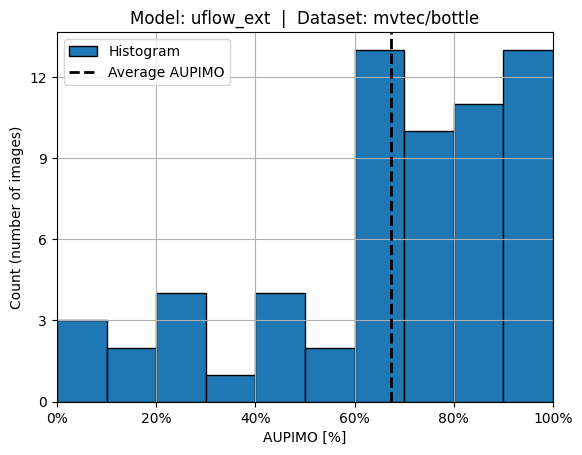

In [8]:
fig, ax = plt.subplots()
ax.hist(data_per_image["aupimo"], bins=np.linspace(0, 1, 11), edgecolor="black", label="Histogram")
ax.axvline(data_per_set.iloc[0]["aupimo_mean"], color="black", label="Average AUPIMO", linestyle="--", linewidth=2)
ax.set_ylabel("Count (number of images)")
ax.yaxis.set_major_locator(MaxNLocator(5, integer=True))
ax.set_xlim(0, 1)
ax.set_xlabel("AUPIMO [%]")
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.grid()
ax.set_title(f"Model: {data_per_set.iloc[0]['model']}  |  Dataset: {data_per_set.iloc[0]['dataset']}")
ax.legend(loc="upper left")
fig  # noqa: B018, RUF100

Let's see the score distributions _per anomaly type_.

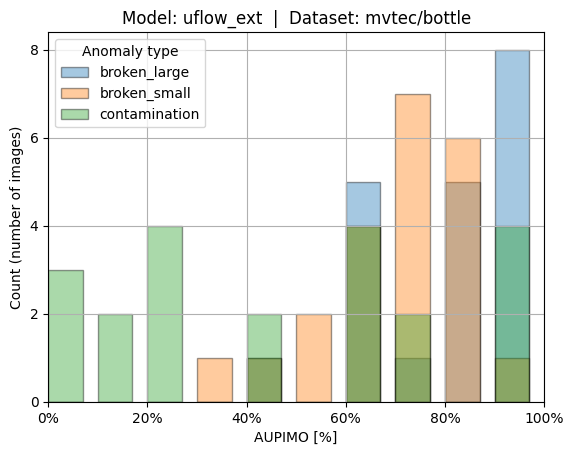

In [9]:
data_per_image["label"] = data_per_image["path"].map(lambda path: path.split("/")[-2])

fig, ax = plt.subplots()
data_per_image.query("label != 'good'").groupby("label", observed=True)["aupimo"].plot.hist(
    ax=ax,
    bins=np.linspace(0, 1, 11),
    edgecolor="black",
    alpha=0.4,
    width=0.07,
)
ax.set_ylabel("Count (number of images)")
ax.yaxis.set_major_locator(MaxNLocator(5, integer=True))
ax.set_xlim(0, 1)
ax.set_xlabel("AUPIMO [%]")
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.grid()
ax.set_title(f"Model: {data_per_set.iloc[0]['model']}  |  Dataset: {data_per_set.iloc[0]['dataset']}")
ax.legend(loc="upper left", title="Anomaly type")
fig  # noqa: B018, RUF100

# Single model, all datasets

In [10]:
# this will download the aupimo scores for all datasets given a single model
data_per_set, data_per_image = get_aupimo_benchmark(model="uflow_ext", dataset=None)

In [11]:
# per dataset information
data_per_set.head(3)

,model,dataset,fpr_lower_bound,fpr_upper_bound,num_thresholds,thresh_lower_bound,thresh_upper_bound,aupimo_mean
0,uflow_ext,mvtec/bottle,0.00001,0.00010,None,0.64445,0.66532,0.67385
1,uflow_ext,mvtec/cable,0.00001,0.00010,None,0.67087,0.72576,0.45526
2,uflow_ext,mvtec/capsule,0.00001,0.00010,None,0.69652,0.72630,0.83383


In [12]:
# per image information
data_per_image.head(3)

,model,dataset,sample_index,aupimo,path
0,uflow_ext,mvtec/bottle,0,0.95297,MVTec/bottle/test/broken_large/000.png
1,uflow_ext,mvtec/bottle,1,0.91126,MVTec/bottle/test/broken_large/001.png
2,uflow_ext,mvtec/bottle,2,0.92038,MVTec/bottle/test/broken_large/002.png


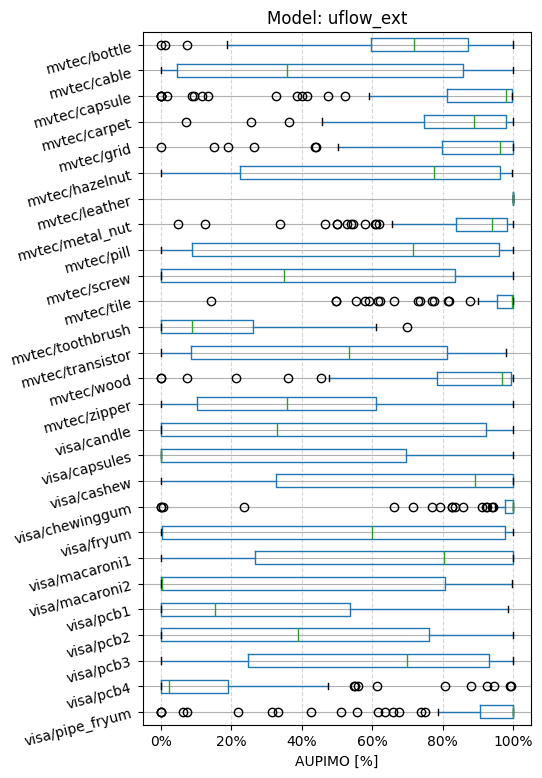

In [13]:
fig, ax = plt.subplots(figsize=(5, 9))
table = data_per_image.dropna(axis=0).pivot_table(
    index="sample_index",
    columns="dataset",
    values="aupimo",
    observed=True,
)
table.boxplot(vert=False, rot=15, grid=True, ax=ax)
ax.invert_yaxis()
ax.set_xlabel("AUPIMO [%]")
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_title(f"Model: {data_per_set.iloc[0]['model']}")
ax.grid(axis="x", linestyle="--", alpha=0.5)
fig  # noqa: B018, RUF100

# All models on a single dataset

In [14]:
# this will download the aupimo scores for all models given a single dataset
data_per_set, data_per_image = get_aupimo_benchmark(model=None, dataset="mvtec/zipper")

In [15]:
# per model information
data_per_set.tail(3)

,model,dataset,fpr_lower_bound,fpr_upper_bound,num_thresholds,thresh_lower_bound,thresh_upper_bound,aupimo_mean
10,rd++_wr50_ext,mvtec/zipper,0.00001,0.00010,None,0.50659,0.56788,0.31626
11,simplenet_wr50_ext,mvtec/zipper,0.00001,0.00010,None,1.06594,1.22361,0.75264
12,uflow_ext,mvtec/zipper,0.00001,0.00010,None,0.72529,0.80578,0.38509


In [16]:
# per image information
data_per_image.head(3)

,model,dataset,sample_index,aupimo,path
0,efficientad_wr101_m_ext,mvtec/zipper,0,0.20912,MVTec/zipper/test/broken_teeth/000.png
1,efficientad_wr101_m_ext,mvtec/zipper,1,0.32493,MVTec/zipper/test/broken_teeth/001.png
2,efficientad_wr101_m_ext,mvtec/zipper,2,0.30946,MVTec/zipper/test/broken_teeth/002.png


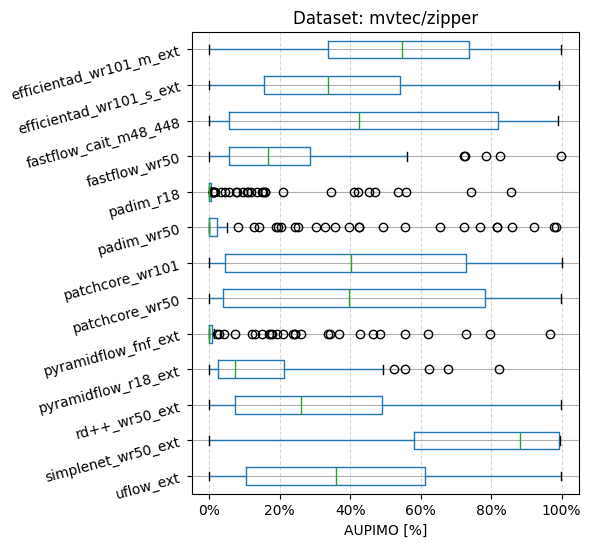

In [17]:
fig, ax = plt.subplots(figsize=(5, 6))
table = data_per_image.dropna(axis=0).pivot_table(index="sample_index", columns="model", values="aupimo", observed=True)
table.boxplot(vert=False, rot=15, grid=True, ax=ax)
ax.invert_yaxis()
ax.set_xlabel("AUPIMO [%]")
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_title(f"Dataset: {data_per_set.iloc[0]['dataset']}")
ax.grid(axis="x", linestyle="--", alpha=0.5)
fig  # noqa: B018, RUF100

# Save and load (JSON format)

How can save and publish your AUPIMO scores?

Under the hood, `get_aupimo_benchmark()` is downloading a JSON file and deserializing it.

Let's see operations to convert to/from this JSON format. 

In [18]:
# download the results from the benchmark
dic = download_aupimo_benchmark_scores(model="uflow_ext", dataset="mvtec/cable")
print(f"{dic.keys()=}")

# it returns the result in two formats
json_dict, aupimo_result = dic["uflow_ext", "mvtec/cable"]

# the raw deserialized JSON dictionary
print(f"{json_dict.keys()=}")

# and the parsed `AUPIMOResult` object
print(f"{aupimo_result=}")

# this is not present in the dataclass `AUPIMOResult`
paths = json_dict["paths"]
print(f"{paths[:2]=}")

dic.keys()=dict_keys([('uflow_ext', 'mvtec/cable')])
json_dict.keys()=dict_keys(['shared_fpr_metric', 'fpr_lower_bound', 'fpr_upper_bound', 'num_threshs', 'thresh_lower_bound', 'thresh_upper_bound', 'aupimos', 'paths'])
aupimo_result=AUPIMOResult(fpr_lower_bound=1e-05, fpr_upper_bound=0.0001, num_thresholds=None)
paths[:2]=['MVTec/cable/test/bent_wire/000.png', 'MVTec/cable/test/bent_wire/001.png']


Saving from the runtime returned value to a file (`AUPIMOResult` -> `dict`)

> Recall that the functional and torchmetrics API return `AUPIMOResult` objects
>
> See the notebook [701a_aupimo.ipynb](./701a_aupimo.ipynb).

In [19]:
payload = aupimo_result_to_json_dict(aupimo_result)
print(f"{payload.keys()=}")

# you can optionally save the paths to the images
# where the AUPIMO scores were computed from
payload = aupimo_result_to_json_dict(aupimo_result, paths=paths)
print(f"{payload.keys()=}")

payload.keys()=dict_keys(['fpr_lower_bound', 'fpr_upper_bound', 'num_thresholds', 'thresh_lower_bound', 'thresh_upper_bound', 'aupimos'])
payload.keys()=dict_keys(['fpr_lower_bound', 'fpr_upper_bound', 'num_thresholds', 'thresh_lower_bound', 'thresh_upper_bound', 'aupimos', 'paths'])


Let's check that it can be saved to a file and loaded back.

In [20]:
from tempfile import TemporaryDirectory

with TemporaryDirectory() as tmpdir:
    cache_dir = Path(tmpdir)

    # SAVE
    payload = aupimo_result_to_json_dict(aupimo_result, paths=paths)
    with (cache_dir / "aupimo_result.json").open("w") as file_out:
        json.dump(payload, file_out, indent=4)

    !du -sh {cache_dir / "aupimo_result.json"}
    !head -n 10 {cache_dir / "aupimo_result.json"}

    # LOAD
    with (cache_dir / "aupimo_result.json").open("r") as file_in:
        payload_reloaded = json.load(file_in)

# compare the original and reloaded objects
aupimo_result_reloaded = aupimo_result_from_json_dict(payload_reloaded)
assert torch.allclose(aupimo_result.aupimos, aupimo_result_reloaded.aupimos, equal_nan=True)

12K	/tmp/tmp5ji7o55e/aupimo_result.json
{
    "fpr_lower_bound": 1e-05,
    "fpr_upper_bound": 0.0001,
    "num_thresholds": null,
    "thresh_lower_bound": 0.6708730459213257,
    "thresh_upper_bound": 0.7257592082023621,
    "aupimos": [
        0.7839027033058256,
        0.9115826454761932,
        0.5865399118429107,


# Compare your own scores

Let's make a quick traing and evaluation of a model and compare it with the benchmark.

In [ ]:
# train the model
task = TaskType.SEGMENTATION
datamodule = MVTec(
    root=dataset_root,
    category="zipper",
    task=task,
    # warning, this will make an unfair comparison with the benchmark
    # because the test will be in lower resolution
    # we're overseeing this issue here for the sake of simplicity and speed
    image_size=256,
)
model = Padim(layers=["layer1"], n_features=64, backbone="resnet18", pre_trained=True)
engine = Engine(pixel_metrics="AUPIMO", logger=False)
engine.fit(datamodule=datamodule, model=model)
predictions = engine.predict(dataloaders=datamodule.test_dataloader(), model=model, return_predictions=True)

# with `False` all the values are returned in a dataclass
aupimo = AUPIMO(return_average=False)

labels = []
for batch in predictions:
    labels.append(batch["label"])
    aupimo.update(anomaly_maps=batch["anomaly_maps"].squeeze(dim=1), masks=batch["mask"])
labels = torch.cat(labels, dim=0)

_, aupimo_result = aupimo.compute()

Combine the results from the benchmark with the new results and plot them together.

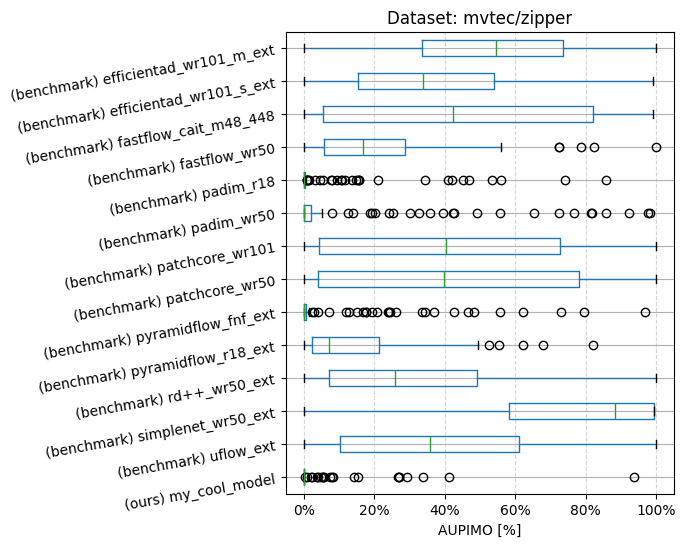

In [22]:
# re-fetch the benchmark results
_, data_per_image = get_aupimo_benchmark(model=None, dataset="mvtec/zipper")
data_benchmark = data_per_image[["model", "aupimo"]].copy()
data_benchmark["from"] = "benchmark"

# create a DataFrame with the results of our model
data_ours = pd.DataFrame({"aupimo": aupimo_result.aupimos})
data_ours["model"] = "my_cool_model"
data_ours["from"] = "ours"

# concatenate the two DataFrames
data_compare = pd.concat([data_benchmark, data_ours], axis=0)

# plot the results
fig, ax = plt.subplots(figsize=(5, 6))
grouped = data_compare.groupby(["from", "model"])
grouped.boxplot(vert=False, rot=10, grid=True, ax=ax, subplots=False)
ax.invert_yaxis()
ax.set_xlabel("AUPIMO [%]")
ax.xaxis.set_major_formatter(PercentFormatter(1))


def fmt_yticklabel(string: str) -> str:
    """Better format for the y-tick labels."""
    parts = string[1:-1].split(", ")
    return f"({parts[0]}) {parts[1]}"


ax.set_yticklabels([fmt_yticklabel(tick.get_text()) for tick in ax.get_yticklabels()])
ax.set_title(f"Dataset: {data_per_set.iloc[0]['dataset']}")
ax.grid(axis="x", linestyle="--", alpha=0.5)
fig  # noqa: B018, RUF100

# Cite Us

AUPIMO was developed during [Google Summer of Code 2023 (GSoC 2023)](https://summerofcode.withgoogle.com/archive/2023/projects/SPMopugd) with the `anomalib` team from Intel's OpenVINO Toolkit.

arXiv: [arxiv.org/abs/2401.01984](https://arxiv.org/abs/2401.01984) (accepted to BMVC 2024)

Official repository: [github.com/jpcbertoldo/aupimo](https://github.com/jpcbertoldo/aupimo) (numpy-only API and numba-accelerated versions available)

```bibtex
@misc{bertoldo2024aupimo,
      author={Joao P. C. Bertoldo and Dick Ameln and Ashwin Vaidya and Samet Akçay},
      title={{AUPIMO: Redefining Visual Anomaly Detection Benchmarks with High Speed and Low Tolerance}}, 
      year={2024},
      url={https://arxiv.org/abs/2401.01984}, 
}
```